# Notebook for training and testing machine learning models

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# testing and training
from sklearn.model_selection import train_test_split

# pre processing
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# regression models
from sklearn.linear_model import LinearRegression

# evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [52]:
# Loading the data
df = pd.read_parquet("../data/processed/player_week_features.parquet")
display(df)      

,player_id,player_name,position,team,opp,season,week,fantasy_points,fp_avg_3,fp_std_3,...,rz_targets,gl_targets,rz_carries,gl_carries,def_fp_allowed_last3,team_points,roof,avg_temp,avg_wind,avg_air_yards
0,00-0033906,A.Kamara,RB,NO,TB,2020,1,23.70,20.966667,2.369247,...,2.0,0.0,4.0,2.0,16.233333,34.0,dome,NaN,NaN,0.375000
1,00-0033923,K.Hunt,RB,CLE,BAL,2020,1,12.10,8.933333,2.843120,...,0.0,0.0,1.0,1.0,19.373333,6.0,outdoors,76.0,5.0,0.166667
2,00-0033948,J.Williams,RB,GB,MIN,2020,1,8.20,4.366667,3.329164,...,1.0,0.0,2.0,1.0,29.300000,43.0,dome,NaN,NaN,-1.500000
3,00-0033951,M.Mack,RB,IND,JAX,2020,1,8.60,15.466667,6.000278,...,0.0,0.0,0.0,0.0,32.533333,20.0,outdoors,80.0,3.0,-0.333333
4,00-0034109,P.Lindsay,RB,DEN,TEN,2020,1,4.50,9.866667,8.611814,...,1.0,0.0,1.0,1.0,20.500000,14.0,outdoors,79.0,10.0,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215311,00-0035125,A.Ingold,FB,LV,NYJ,2019,12,0.00,2.833333,4.650090,...,NaN,NaN,0.0,0.0,0.400000,NaN,None,NaN,NaN,NaN
215312,00-0031280,D.Carr,QB,LV,KC,2019,13,11.58,12.513333,7.841769,...,NaN,NaN,0.0,0.0,17.453333,NaN,None,NaN,NaN,NaN
215313,00-0032423,T.Davis,WR,LV,KC,2019,13,0.00,0.000000,0.000000,...,NaN,NaN,0.0,0.0,23.566667,NaN,None,NaN,NaN,NaN
215314,00-0031280,D.Carr,QB,LV,JAX,2019,15,15.88,15.880000,4.300000,...,NaN,NaN,0.0,0.0,24.560000,NaN,None,NaN,NaN,NaN


In [ ]:

TARGET = "fantasy_points"
ID_COLS = ["player_id", "player_name"]
NON_PRED_IDX = ["season", "week", "team", "opp"]
ENCODED_COLS = ["roof", "position"]

regression_model = LinearRegression()

X = df.drop(columns=[c for c in ID_COLS + [TARGET] + NON_PRED_IDX if c in df.columns])
y = df[TARGET].astype(float)

cols_with_strings = [c for c in ENCODED_COLS if c in X.columns]
cols_with_numbers = selector(dtype_include=["number"])(X.drop(columns=cols_with_strings, errors="ignore"))

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler(with_mean=True, with_std=True)),
])

# uses one hot encoding to encode the categorical columns
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("numerical", numeric_pipe, cols_with_numbers),
        ("categorical", categorical_pipe, cols_with_strings),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

model = Pipeline([
    ("preprocess", preprocess),
    ("reg", regression_model),
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)
print(f"MAE={mae:.5f}  MSE={mse:.5f}  R^2={r2:.5f}")

feat_names = model.named_steps["preprocess"].get_feature_names_out()
print("n_features =", len(feat_names))

MAE=1.19448  MSE=6.46806  R^2=0.81909
n_features = 43


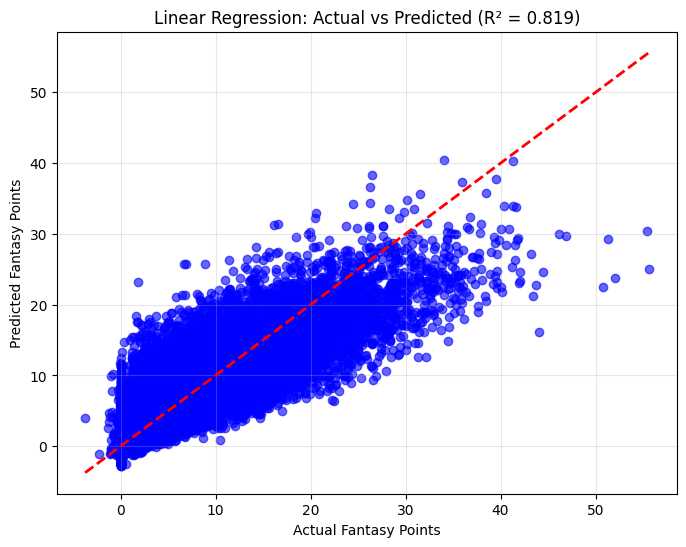

In [80]:
# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Fantasy Points')
plt.ylabel('Predicted Fantasy Points')
plt.title(f'Linear Regression: Actual vs Predicted (R² = {r2:.3f})')
plt.grid(True, alpha=0.3)
plt.show()